In [89]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from pprint import pprint
import pandas as pd

In [56]:
# Prevenindo o uso de GPU (não compensa -- overhead maior que ganho)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [57]:
# seed para reprodutibilidade
np.random.seed(342016)

## Redes neurais

### Feedforward

In [58]:
dt = 0.01; T = 8; t = np.arange(0,T+dt,dt)
beta = 8/3; sigma = 10; rho = 28
nn_input = np.zeros((100*(len(t)-1),3))
nn_output = np.zeros_like(nn_input)

def lorenz_deriv(x_y_z,t0,sigma=sigma,beta=beta,rho=rho):
    x, y, z = x_y_z
    return [sigma*(y-x), x*(rho-z)-y, x*y-beta*z]

x0 = -15 + 30 * np.random.random((100, 3))
x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t) for x0_j in x0])

for j in range(100):
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]

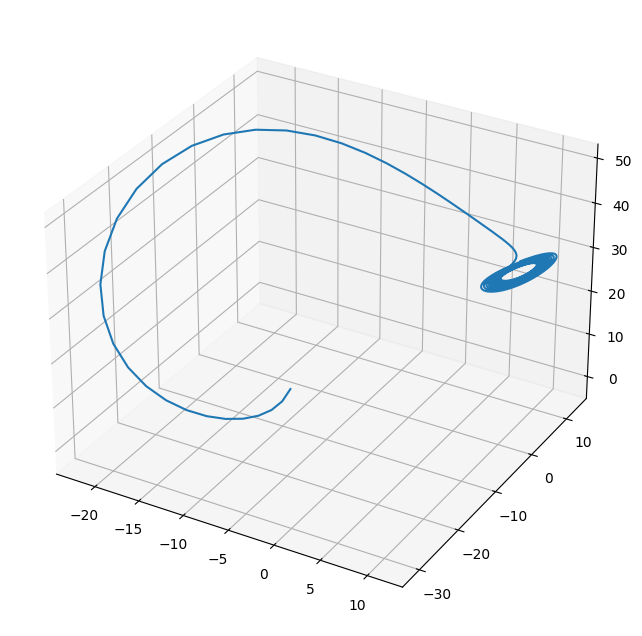

In [59]:
# (100, 801, 3)
# 100 trajetórias, 801 pontos, 3 dimensões
# plot de uma trajetória (3d)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
ax.plot(x_t[0,:,0], x_t[0,:,1], x_t[0,:,2])
plt.show()

In [60]:
net = keras.models.Sequential()
net.add(layers.Dense(10, input_dim=3, activation='sigmoid'))
net.add(layers.Dense(10, activation='relu'))
net.add(layers.Dense(3, activation='linear'))
net.compile(loss='mse', optimizer='adam')
History = net.fit(nn_input, nn_output, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 2s 784us/step - loss: 57.5571
Epoch 2/30
2500/2500 [==============================] - 2s 816us/step - loss: 2.7628
Epoch 3/30
2500/2500 [==============================] - 2s 842us/step - loss: 0.8305
Epoch 4/30
2500/2500 [==============================] - 2s 865us/step - loss: 0.4292
Epoch 5/30
2500/2500 [==============================] - 2s 818us/step - loss: 0.2805
Epoch 6/30
 188/2500 [=>............................] - ETA: 1s - loss: 0.2419

KeyboardInterrupt: 

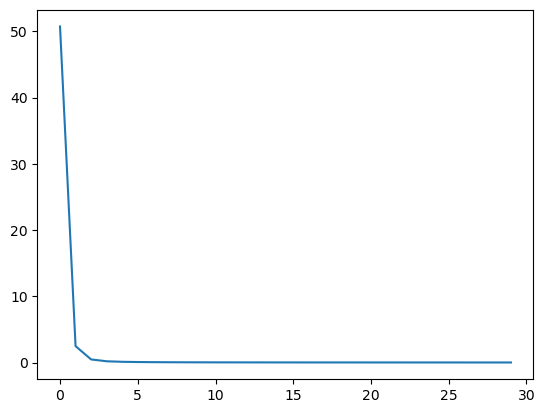

In [ ]:
# plot loss history
plt.plot(History.history['loss'])

Melhor do que tentar prever próximos estados destas trajetórias existentes, vamos tentar prever o comportamento de duas trajetórias completamente novas (mas integrantes ao sistema para qual a rede foi treinada).

In [ ]:
# 2 trajetórias
num_traj = 2

ynn = np.zeros((num_traj, len(t), 3))
ynn[:, 0, :] = -15 + 30 * np.random.random((num_traj, 3))
print(ynn.shape)
for jj, tval in enumerate(t[:-1]):
    ynn[:, jj+1, :] = net.predict(ynn[:, jj, :], verbose=1)

(2, 801, 3)
1/1 [==============================] - 0s 13ms/step


In [ ]:
ynn.shape

(2, 801, 3)

In [ ]:
# solve ODE, the two trajectories
y_t_1 = integrate.odeint(lorenz_deriv, ynn[0, 0, :], t)
y_t_2 = integrate.odeint(lorenz_deriv, ynn[1, 0, :], t)
y_t_1

array([[ 4.72297734,  9.97949775, 12.22511434],
       [ 5.25552904, 10.6588341 , 12.41155582],
       [ 5.80523182, 11.40311677, 12.68704748],
       ...,
       [-3.73892692, -4.66418307, 19.29354674],
       [-3.84076481, -4.95225963, 18.96559478],
       [-3.96124421, -5.25952431, 18.66300645]])

In [ ]:
y_t_2

array([[-14.00846108,  -8.41626234,   2.62607521],
       [-13.63900285, -11.72992551,   3.93136858],
       [-13.60601553, -14.75998278,   5.60882133],
       ...,
       [  6.05668798,   7.56035759,  21.4724607 ],
       [  6.215466  ,   7.88675643,  21.37502976],
       [  6.39081652,   8.22583387,  21.31360589]])

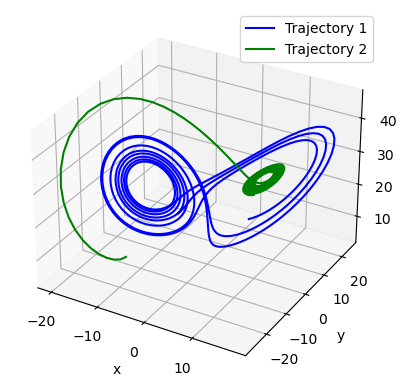

In [ ]:
# plot y_t_1 and y_t_2 (blue and green)
# 3d
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(y_t_1[:, 0], y_t_1[:, 1], y_t_1[:, 2], 'b')
ax.plot(y_t_2[:, 0], y_t_2[:, 1], y_t_2[:, 2], 'g')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# blue label = trajectory 1
# green label = trajectory 2
plt.legend(['Trajectory 1', 'Trajectory 2'])
plt.show()

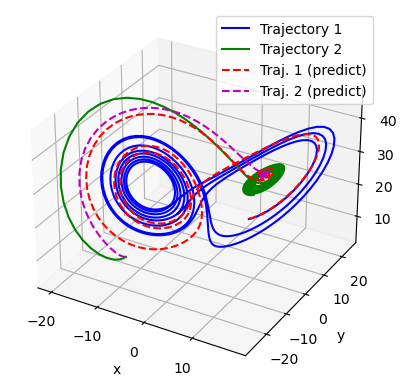

In [ ]:
# plot y_t_1 and y_t_2 (blue and green)
# 3d
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(y_t_1[:, 0], y_t_1[:, 1], y_t_1[:, 2], 'b')
ax.plot(y_t_2[:, 0], y_t_2[:, 1], y_t_2[:, 2], 'g')
# ynn = np.zeros((num_traj, len(t), 3))
ynn_1 = ynn[0, :, :]
ynn_2 = ynn[1, :, :]
# plot ynn_1 (red, dotted line)
ax.plot(ynn_1[:, 0], ynn_1[:, 1], ynn_1[:, 2], 'r--')
# plot ynn_2 (pink, dotted line)
ax.plot(ynn_2[:, 0], ynn_2[:, 1], ynn_2[:, 2], 'm--')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# blue label = trajectory 1
# green label = trajectory 2
plt.legend(['Trajectory 1', 'Trajectory 2', 'Traj. 1 (predict)', 'Traj. 2 (predict)'])
plt.show()

In [ ]:
# TODO: comentar melhor

### RNN (LSTM)

In [ ]:
sequence_size = 40; train_size = 80; test_size = 20

rnn_input = np.zeros((train_size*(len(t)-sequence_size-1), sequence_size, 3))
rnn_output = np.zeros((train_size*(len(t)-sequence_size-1), 3))

for j in range(train_size):
    for k in range(len(t)-sequence_size-1):
        rnn_input[j*(len(t)-sequence_size-1) + k,:] = x_t[j,k:k+sequence_size,:]
        rnn_output[j*(len(t)-sequence_size-1) + k,:] = x_t[j,k+sequence_size,:]

model = keras.models.Sequential()
model.add(layers.LSTM(16, input_shape=(None, 3)))
# model.add(SimpleRNN(16, input_shape=(None, 3)))
model.add(layers.Dense(3))
sgd = optimizers.SGD(0.01)
model.compile(optimizer=sgd, loss='mean_squared_error')

2023-05-19 05:11:00.550671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 05:11:00.551984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 05:11:00.553216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
model.fit(rnn_input, rnn_output, epochs=50)

Epoch 1/50


2023-05-19 05:11:01.074553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 05:11:01.076313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 05:11:01.077633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1900/1900 [==============================] - 20s 10ms/step - loss: 9.3354
Epoch 2/50
1900/1900 [==============================] - 19s 10ms/step - loss: 1.8763
Epoch 3/50
1900/1900 [==============================] - 19s 10ms/step - loss: 1.0361
Epoch 4/50
1900/1900 [==============================] - 18s 10ms/step - loss: 0.8406
Epoch 5/50
1900/1900 [==============================] - 18s 9ms/step - loss: 0.6218
Epoch 6/50
1900/1900 [==============================] - 18s 10ms/step - loss: 0.5532
Epoch 7/50
1900/1900 [==============================] - 18s 10ms/step - loss: 0.4800
Epoch 8/50
1900/1900 [==============================] - 19s 10ms/step - loss: 0.7948
Epoch 9/50
1900/1900 [==============================] - 19s 10ms/step - loss: 0.4625
Epoch 10/50
1900/1900 [==============================] - 19s 10ms/step - loss: 0.3603
Epoch 11/50
1900/1900 [==============================] - 19s 10ms/step - loss: 0.3249
Epoch 12/50
1900/1900 [==============================] - 19s 10ms/step - lo

In [ ]:
first_point = -15 + 30 * np.random.random((1, 3))
ynn = np.zeros((1, test_size, 3))
ynn[0, 0, :] = first_point

In [ ]:
# solve ODE for the first point
y_t = integrate.odeint(lorenz_deriv, ynn[0, 0, :], t[:test_size])
y_t.shape

(20, 3)

In [ ]:
for i in range(1, test_size):
    prediction = model.predict(ynn[:, :i, :])
    ynn[:, i, :] = prediction

1/1 [==============================] - 0s 16ms/step


In [ ]:
ynn.shape

(1, 20, 3)

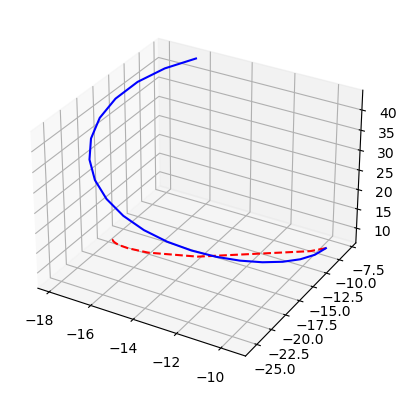

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(ynn[0, :, 0], ynn[0, :, 1], ynn[0, :, 2], 'r--')
ax.plot(y_t[:, 0], y_t[:, 1], y_t[:, 2], 'b')

## Métodos numéricos

### SINDy

In [171]:
dt = 0.01
T = 50
t = np.arange(dt,T+dt,dt)
beta = 8/3
sigma = 10
rho = 28
n = 3

def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = (-8,8,27)

x = integrate.odeint(lorenz_deriv, x0, t,rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))

In [172]:
## Compute Derivative
dx = np.zeros_like(x)
for j in range(len(t)):
    dx[j,:] = lorenz_deriv(x[j,:],0,sigma,beta,rho)

In [173]:
## SINDy Function Definitions

def poolData(yin,nVars,polyorder):
    n = yin.shape[0]
    yout = np.zeros((n,1))
    
    # poly order 0
    yout[:,0] = np.ones(n)
    
    # poly order 1
    for i in range(nVars):
        yout = np.append(yout,yin[:,i].reshape((yin.shape[0],1)),axis=1)
    
    # poly order 2
    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i,nVars):
                yout = np.append(yout,(yin[:,i]*yin[:,j]).reshape((yin.shape[0],1)),axis=1)
                
    # poly order 3
    if polyorder >= 3:
        for i in range(nVars):
            for j in range(i,nVars):
                for k in range(j,nVars):
                    yout = np.append(yout,(yin[:,i]*yin[:,j]*yin[:,k]).reshape((yin.shape[0],1)),axis=1)
    
    return yout

def sparsifyDynamics(Theta,dXdt,lamb,n):
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares
    
    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coefficients
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]
            
    return Xi

In [174]:
Theta = poolData(x,n,3) # Up to third order polynomials
lamb = 0.025 # sparsification knob lambda
Xi = sparsifyDynamics(Theta,dx,lamb,n)
Xi

array([[  0.        ,   0.        ,   0.        ],
       [-10.        ,  28.        ,   0.        ],
       [ 10.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,  -2.66666667],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ],
       [  0.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.     

## PySINDy teste

In [181]:
import pysindy as ps

NameError: name 'mode' is not defined

In [187]:
x0 = (-8,8,27)
model = ps.SINDy(feature_names=['x','y','z'])
model.fit(x, t=t, x_dot=dx)
# plot model
model.print()
model.simulate(x[0], t)

(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y
[-8.  8. 27.]
